# Team 6 Final Project
Chaim Gross, Eytan Slotnik, Tomer Fried, Naftali Arnold
## 11/01/2023

After going through the map which presents fires by their causes, and trying to create location-based features, we have gotten to see that:
- The location-based features, which are based on data that latitude and longitude features already produce, do not improve accuracy significantly
- The reason for that might be that latitude and longitude already explain their variance within them

Therefore, we decided to swift our efforts to feature engineering which is based on data, that does not already apparent, but rather missing in the data, such as:
- Social- Economic data, location based
- Density of population, location based

So as a start, we add these, using datasets in kaggle, which occur in the US at similar times:

In [30]:
import pandas as pd
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.express as px
import numpy as np
import datetime
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import folium
import xgboost as xgb
from tensorflow.keras.utils import to_categorical
import rtree
import haversine
from sklearn import preprocessing

In [43]:
def create_date_faetures(df):
    """
    creates data features from YEAR and DOY.
    create a new column of date which is calculated from FIRE_YEAR and DISCOVERY_DOY, and extract from there features
    :param df: data
    :return: a new dataframe containing only the features we added
    """
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

    features = pd.DataFrame()
    df["DISCOVERY_DATE"] = pd.to_datetime(df['FIRE_YEAR'] * 1000 + df['DISCOVERY_DOY'], format='%Y%j')
    cal = calendar()

    # is holiday feature
    holidays = cal.holidays(start=df["DISCOVERY_DATE"].min(), end=df["DISCOVERY_DATE"].max())
    features['IS_HOLIDAY'] = df['DISCOVERY_DATE'].isin(holidays).astype(int)

    # is fourth of july feature
    features['IS_4TH_JULY'] = df['DISCOVERY_DATE'].apply(lambda date: 1 if date.strftime("%B %d") == "July 04" else 0)

    # is weekend feature
    features['IS_WEEKEND'] = dayofweek = df["DISCOVERY_DATE"].dt.dayofweek
    features['IS_WEEKEND'][dayofweek >= 5] = 1
    features['IS_WEEKEND'][dayofweek < 5]  = 0

    features["WEST_TO_10W"] = np.where(df['LONGITUDE'] >= -100, 1, 0)

    # month dummies
    month_dummies = pd.get_dummies(df["DISCOVERY_DATE"].dt.month, prefix="MONTH", drop_first=True)
    features = pd.concat([features, month_dummies], axis=1)

    return features



In [44]:
def add_density_features(df):

    us_state_to_abbrev = {
        "Alabama": "AL",
        "Alaska": "AK",
        "Arizona": "AZ",
        "Arkansas": "AR",
        "California": "CA",
        "Colorado": "CO",
        "Connecticut": "CT",
        "Delaware": "DE",
        "Florida": "FL",
        "Georgia": "GA",
        "Hawaii": "HI",
        "Idaho": "ID",
        "Illinois": "IL",
        "Indiana": "IN",
        "Iowa": "IA",
        "Kansas": "KS",
        "Kentucky": "KY",
        "Louisiana": "LA",
        "Maine": "ME",
        "Maryland": "MD",
        "Massachusetts": "MA",
        "Michigan": "MI",
        "Minnesota": "MN",
        "Mississippi": "MS",
        "Missouri": "MO",
        "Montana": "MT",
        "Nebraska": "NE",
        "Nevada": "NV",
        "New Hampshire": "NH",
        "New Jersey": "NJ",
        "New Mexico": "NM",
        "New York": "NY",
        "North Carolina": "NC",
        "North Dakota": "ND",
        "Ohio": "OH",
        "Oklahoma": "OK",
        "Oregon": "OR",
        "Pennsylvania": "PA",
        "Rhode Island": "RI",
        "South Carolina": "SC",
        "South Dakota": "SD",
        "Tennessee": "TN",
        "Texas": "TX",
        "Utah": "UT",
        "Vermont": "VT",
        "Virginia": "VA",
        "Washington": "WA",
        "West Virginia": "WV",
        "Wisconsin": "WI",
        "Wyoming": "WY",
        "District of Columbia": "DC",
        "American Samoa": "AS",
        "Guam": "GU",
        "Northern Mariana Islands": "MP",
        "Puerto Rico": "PR",
        "United States Minor Outlying Islands": "UM",
        "U.S. Virgin Islands": "VI",
    }
    us_abbrev_to_state = {v: k for k, v in us_state_to_abbrev.items()}

    density_df = pd.read_csv("apportionment.csv")

    df["ROUNDED_YEAR"] = df["FIRE_YEAR"].apply(lambda x: (x//10) * 10)
    df["DENSITY"] = df.apply(
        lambda row: density_df[(density_df["Name"] == us_abbrev_to_state[row["STATE"]]) &
                               (density_df["Year"] == row["ROUNDED_YEAR"])][["Resident Population Density"]].values[0, 0], axis=1).values

    return df

In [45]:
def pre_process_data(data):
    data = add_density_features(data)
    features = create_date_faetures(data)
    data = data.merge(features, left_index=True, right_index=True)

    # One-Hot Encoding
    for f in ['STATE', 'FIRE_YEAR']: # add months
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(data['FIRE_SIZE_CLASS'])
    data['FIRE_SIZE_CLASS'] = le.transform(data['FIRE_SIZE_CLASS']) + 1

    def is_south_east_state(df):
        return df["STATE_FL"]+df["STATE_AL"]+df["STATE_GA"]+df["STATE_SC"]+df["STATE_MS"]+df["STATE_TN"]+df["STATE_NC"]

    data["IS_SOUTH_EAST"] = np.where(is_south_east_state(data) == 1, 1, 0)

    columns_to_drop = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'NWCG_REPORTING_UNIT_ID',
               'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
               'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME','COMPLEX_NAME', 'OWNER_CODE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', "Shape", "DISCOVERY_TIME", "CONT_TIME",
               "OWNER_DESCR", "DISCOVERY_DATE", "DISCOVERY_DOY", "CONT_DOY", "CONT_DATE", "FIRE_SIZE",
                "SOURCE_SYSTEM", "SOURCE_SYSTEM_TYPE", "NWCG_REPORTING_AGENCY", "STAT_CAUSE_DESCR"]

    data = data.drop(columns = columns_to_drop)

    return data



In [46]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
raw_df = pd.read_sql_query("SELECT * from Fires", conn)
raw_df["STAT_CAUSE_CODE"] = raw_df["STAT_CAUSE_CODE"].astype(int)
X, y = raw_df.drop(columns = ["STAT_CAUSE_CODE"]), raw_df.filter(items = ["STAT_CAUSE_CODE"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
df = X_train.merge(y_train, left_index=True, right_index=True)
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_3672\2807412305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['IS_WEEKEND'][dayofweek >= 5] = 1
C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_3672\2807412305.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['IS_WEEKEND'][dayofweek < 5]  = 0
C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_3672\2807412305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [47]:
income_df = pd.read_csv("kaggle_income.csv", encoding="latin1").drop_duplicates(subset=['Lat', "Lon"])
income_locations = [(row["Lat"], row["Lon"]) for _, row in income_df.iterrows()]

In [48]:
def create_index(locations):
    index = rtree.index.Index()
    for i, location in enumerate(locations):
        index.insert(i, location)
    return index

index = create_index(income_locations)
def add_income_features(df):

    def find_closest_location(target_row):
        target_location = (target_row["LATITUDE"], target_row["LONGITUDE"])
        closest_location = None
        closest_distance = float("inf")
        for i in index.nearest(target_location, 1):
            location = income_locations[i]
            distance = haversine.haversine(location, target_location)
            if distance < closest_distance:
                closest_location = location
                closest_distance = distance
        return closest_location

    df["closest_location"] = df.apply(find_closest_location, axis=1)

    df[['Lat', 'Lon']] = df["closest_location"].apply(lambda x: pd.Series(x))
    df = pd.merge(df, income_df, on=['Lat', 'Lon'], how="left")
    df = df.drop(columns = ['id', 'State_Code', 'State_Name', 'State_ab', 'Zip_Code', 'Area_Code', 'Lat', "Lon", 'closest_location'])
    return df

In [49]:
X_train = add_income_features(X_train)
X_test = add_income_features(X_test)

In [50]:
def encode_income_columns(data):
    # One-Hot Encoding
    for f in ['Type', 'Primary']:
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    le = preprocessing.LabelEncoder()
    for c in ['County', 'City', 'Place']:
        le.fit(data[c])
        data[c] = le.transform(data[c]) + 1

    return data

In [51]:
X_train = encode_income_columns(X_train)
X_test = encode_income_columns(X_test)

In [73]:
X_train['DENSITY'] = X_train['DENSITY'].str.replace(',','').astype(float)
X_test['DENSITY'] = X_test['DENSITY'].str.replace(',','').astype(float)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_3672\1897862076.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)


Random Forest accuracy score is:
0.5525442548466555
Random Forest F1 score is:
              precision    recall  f1-score   support

           1       0.70      0.80      0.75     23271
           2       0.37      0.25      0.29     12469
           3       0.21      0.06      0.09      4428
           4       0.43      0.25      0.32      6387
           5       0.50      0.67      0.58     35799
           6       0.47      0.41      0.44      2753
           7       0.54      0.51      0.52     23178
           8       0.30      0.13      0.18      5139
           9       0.48      0.51      0.50     26972
          10       0.53      0.36      0.43       994
          11       0.20      0.06      0.09      1177
          12       0.09      0.02      0.03       310
          13       0.84      0.83      0.83     13829

    accuracy                           0.55    156706
   macro avg       0.44      0.37      0.39    156706
weighted avg       0.53      0.55      0.53    156706



[('LONGITUDE', 0.13646647461673142),
 ('LATITUDE', 0.12509708493219115),
 ('DENSITY', 0.04537847207655675),
 ('ALand', 0.04391758514142704),
 ('Mean', 0.038088294642434385),
 ('Stdev', 0.037811535184583994),
 ('sum_w', 0.03759386879162739),
 ('City', 0.03640638200102585),
 ('Median', 0.03625471198452609),
 ('AWater', 0.03532236109780148),
 ('FIRE_SIZE_CLASS', 0.03216036520071566),
 ('IS_WEEKEND', 0.024469831749215347),
 ('ROUNDED_YEAR', 0.01962873760653393),
 ('County', 0.016137933529474787),
 ('Place', 0.01579612296006692),
 ('WEST_TO_10W', 0.012011470255000534),
 ('MONTH_8', 0.011953467249975501),
 ('MONTH_7', 0.011640375082107765),
 ('MONTH_4', 0.01095835932427063),
 ('MONTH_6', 0.010098902891502247),
 ('MONTH_3', 0.009692375487903322),
 ('MONTH_5', 0.009479468690322528),
 ('FIRE_YEAR_2007', 0.008776339225271998),
 ('MONTH_9', 0.00843826152548281),
 ('MONTH_10', 0.008114423156686472),
 ('FIRE_YEAR_2008', 0.008094600436841817),
 ('FIRE_YEAR_2006', 0.007705922447932372),
 ('FIRE_YEAR_

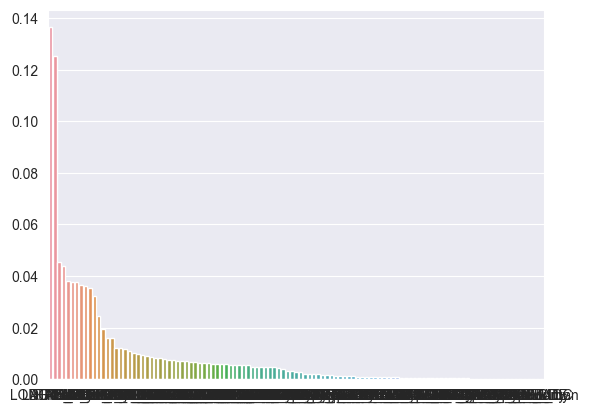

In [74]:
rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest accuracy score is:")
print(accuracy_score(y_test,rf_preds))
print("Random Forest F1 score is:")
print(classification_report(y_test,rf_preds, zero_division=0))

feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)
feature_importances

Wow, an improvement of approximately 3 percent in accuracy. All labels' f1 scores where improved.
Looks like we should continue with this idea in mind, now by adding rainfall data in each state: mean monthly amount of precipitation in a wide range of years:

In [159]:
rainfall_data = pd.read_csv("daily_rainfall_flags_removed.csv")
fips_code_to_abbreviation = {
    '01': 'AL',
    '02': 'AK',
    '04': 'AZ',
    '05': 'AR',
    '06': 'CA',
    '08': 'CO',
    '09': 'CT',
    '10': 'DE',
    '11': 'DC',
    '12': 'FL',
    '13': 'GA',
    '15': 'HI',
    '16': 'ID',
    '17': 'IL',
    '18': 'IN',
    '19': 'IA',
    '20': 'KS',
    '21': 'KY',
    '22': 'LA',
    '23': 'ME',
    '24': 'MD',
    '25': 'MA',
    '26': 'MI',
    '27': 'MN',
    '28': 'MS',
    '29': 'MO',
    '30': 'MT',
    '31': 'NE',
    '32': 'NV',
    '33': 'NH',
    '34': 'NJ',
    '35': 'NM',
    '36': 'NY',
    '37': 'NC',
    '38': 'ND',
    '39': 'OH',
    '40': 'OK',
    '41': 'OR',
    '42': 'PA',
    '44': 'RI',
    '45': 'SC',
    '46': 'SD',
    '47': 'TN',
    '48': 'TX',
    '49': 'UT',
    '50': 'VT',
    '51': 'VA',
    '53': 'WA',
    '54': 'WV',
    '55': 'WI',
    '56': 'WY',
}
rainfall_data["state_code"] = rainfall_data["state_code"].astype(str)
rainfall_data["STATE_ABB"] = rainfall_data['state_code'].map(fips_code_to_abbreviation).astype(str)
rainfall_data["date"]= pd.to_datetime(rainfall_data["date"])
rainfall_data['MONTH'] = rainfall_data['date'].dt.month.astype(int)
grouped_df = rainfall_data.groupby(['STATE_ABB','MONTH'])
mean_df = grouped_df.mean().reset_index().filter(items=['STATE_ABB','MONTH','rainfall'])

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_3672\173076679.py:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = grouped_df.mean().reset_index().filter(items=['STATE_ABB','MONTH','rainfall'])


In [154]:
def add_state_abb_col(df):
    # Extract only the state columns
    state_cols = [col for col in df.columns if col.startswith("STATE_")]
    df_state_cols = df[state_cols]

    # Find the column with the "1" value for each row
    new_df = df.copy(True)
    new_df['STATE_ABB'] = df_state_cols.idxmax(axis=1).str.slice(start=6).astype(str)
    return new_df

In [153]:
def add_month_col(df):
    # Extract only the state columns
    months_cols = [col for col in df.columns if col.startswith("MONTH_")]
    df_months_cols = df[months_cols]

    # Find the column with the "1" value for each row
    new_df = df.copy(True)
    new_df['MONTH'] = df_months_cols.idxmax(axis=1).str.slice(start=6).astype(int)
    return new_df

In [157]:
X_train = add_state_abb_col(X_train)
X_train = add_month_col(X_train)

In [160]:
pd.merge(X_train, mean_df, on=['STATE_ABB', 'MONTH'], how="left")

,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,ROUNDED_YEAR,DENSITY,IS_HOLIDAY,IS_4TH_JULY,IS_WEEKEND,WEST_TO_10W,MONTH_2,...,Type_Community,Type_County,Type_Town,Type_Track,Type_Urban,Type_Village,Primary_place,STATE_ABB,MONTH,rainfall
0,2,31.248900,-93.176700,2000,103.4,0,0,0,1,1,...,0,0,0,0,0,0,1,LA,2,56.069140
1,2,34.816700,-79.433300,2000,165.6,0,0,0,1,1,...,0,0,0,1,0,0,0,NC,2,NaN
2,2,38.697800,-112.172580,2000,27.2,0,0,0,0,0,...,0,0,0,0,0,0,1,UT,7,NaN
3,1,48.256667,-115.970000,2000,6.2,0,0,0,0,0,...,0,0,0,0,0,0,1,MT,8,35.878389
4,2,33.218889,-117.128889,1990,191.0,0,0,0,0,0,...,0,0,0,1,0,0,0,CA,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470111,1,33.881111,-117.218056,2000,217.4,0,0,1,0,0,...,0,0,0,1,0,0,0,CA,9,NaN
470112,1,33.851389,-110.882500,2000,45.2,0,0,0,0,0,...,0,0,0,1,0,0,0,AZ,7,NaN
470113,2,33.641500,-84.794400,1990,112.6,0,0,1,1,0,...,0,0,0,1,0,0,0,GA,3,23.320312
470114,1,33.350000,-80.783300,2000,133.5,0,0,0,1,0,...,0,0,0,1,0,0,0,SC,6,27.230679


In [156]:
X_train = X_train.drop(columns=['STATE_ABB', 'MONTH'])

Not yet working, but stay tuned